# Modelo Final de Previs√£o de Pre√ßos em S√£o Paulo
Este notebook cont√©m o script limpo e consolidado para executar o modelo XGBoost e a fun√ß√£o de previs√£o interativa. Ele removeu todas as c√©lulas de An√°lise Explorat√≥ria de Dados (EDA) e testes de avalia√ß√£o para focar na aplica√ß√£o.

#### 1. Configura√ß√£o e Importa√ß√µes Necess√°rias
Importa as bibliotecas essenciais para manipula√ß√£o de dados, pr√©-processamento e o modelo XGBoost.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor as xgb
from sklearn.pipeline import Pipeline # Mantido para tipagem e compatibilidade
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

#### 2. Prepara√ß√£o de Dados e Mapeamento de Regi√µes
Este bloco carrega o dataset, aplica os filtros de limpeza e define o mapeamento completo dos bairros para suas respectivas zonas, que √© crucial para o encoding categ√≥rico do modelo.

Aten√ß√£o: Voc√™ precisa ajustar o caminho_csv para onde o seu arquivo est√° salvo.

In [2]:
# ‚ö†Ô∏è AJUSTE O CAMINHO DO SEU ARQUIVO CSV AQUI ‚ö†Ô∏è
try:
    caminho_csv = r'C:\Users\luuka\.cache\kagglehub\datasets\argonalyst\sao-paulo-real-estate-sale-rent-april-2019\versions\1\sao-paulo-properties-april-2019.csv' 
    df = pd.read_csv(caminho_csv)
    print("Base de dados carregada com sucesso.")
except FileNotFoundError:
    print("ERRO: O arquivo CSV n√£o foi encontrado. Verifique o caminho.")
    raise

# Filtros e tratamento de dados (Baseado nas etapas do seu notebook original)
df = df[df['Negotiation Type'] == 'sale'].drop(columns=['Negotiation Type', 'Property Type'])
df.dropna(subset=['Price', 'Condo'], inplace=True)
df['bairro'] = df['District'].apply(lambda x: x.split('/')[0].strip())

# Defini√ß√£o Completa do Dicion√°rio de Mapeamento (mapeamento_regioes)
mapeamento_regioes = {
    # Zona Leste
    'Artur Alvim': 'Zona Leste', 'Canga√≠ba': 'Zona Leste', 'Carr√£o': 'Zona Leste', 
    'Cidade L√≠der': 'Zona Leste', 'Cidade Tiradentes': 'Zona Leste', 'Ermelino Matarazzo': 'Zona Leste', 
    'Itaim Paulista': 'Zona Leste', 'Itaquera': 'Zona Leste', 'Jardim Helena': 'Zona Leste', 
    'Jos√© Bonif√°cio': 'Zona Leste', 'Lajeado': 'Zona Leste', 'Parque do Carmo': 'Zona Leste', 
    'Ponte Rasa': 'Zona Leste', 'S√£o Mateus': 'Zona Leste', 'S√£o Miguel': 'Zona Leste', 
    'S√£o Rafael': 'Zona Leste', 'Vila Curu√ß√°': 'Zona Leste', 'Vila Formosa': 'Zona Leste', 
    'Aricanduva': 'Zona Leste', 'Guaianazes': 'Zona Leste', 'Penha': 'Zona Leste', 
    'Tatuap√©': 'Zona Leste', 'Vila Matilde': 'Zona Leste', 'Mooca': 'Zona Leste', 
    'Bel√©m': 'Zona Leste', '√Ågua Rasa': 'Zona Leste', 'Sapopemba': 'Zona Leste', 
    'S√£o Lucas': 'Zona Leste', 'Vila Jacu√≠': 'Zona Leste', 'Vila Prudente': 'Zona Leste', 
    'Iguatemi': 'Zona Leste',
    
    # Zona Sul
    'Campo Belo': 'Zona Sul', 'Campo Grande': 'Zona Sul', 'Campo Limpo': 'Zona Sul', 
    'Cap√£o Redondo': 'Zona Sul', 'Cidade Ademar': 'Zona Sul', 'Cidade Dutra': 'Zona Sul', 
    'Graja√∫': 'Zona Sul', 'Ipiranga': 'Zona Sul', 'Itaim Bibi': 'Zona Sul', 
    'Jabaquara': 'Zona Sul', 'Jardim √Çngela': 'Zona Sul', 'Jardim Paulista': 'Zona Sul', 
    'Moema': 'Zona Sul', 'Morumbi': 'Zona Sul', 'Sacom√£': 'Zona Sul', 
    'Santo Amaro': 'Zona Sul', 'Sa√∫de': 'Zona Sul', 'Socorro': 'Zona Sul', 
    'Vila Andrade': 'Zona Sul', 'Vila Mariana': 'Zona Sul', 'Vila S√¥nia': 'Zona Sul', 
    'Brooklin': 'Zona Sul', 'Vila Olimpia': 'Zona Sul', 'Pedreira': 'Zona Sul', 
    'Cursino': 'Zona Sul', 'Cambuci': 'Zona Sul', 'Jardim S√£o Luis': 'Zona Sul', 
    
    # Zona Oeste
    'Alto de Pinheiros': 'Zona Oeste', 'Butant√£': 'Zona Oeste', 'Jaguar√©': 'Zona Oeste', 
    'Lapa': 'Zona Oeste', 'Perdizes': 'Zona Oeste', 'Pinheiros': 'Zona Oeste', 
    'Vila Leopoldina': 'Zona Oeste', 'Vila Madalena': 'Zona Oeste', 'Raposo Tavares': 'Zona Oeste', 
    'Rio Pequeno': 'Zona Oeste', 'Pirituba': 'Zona Oeste', 'Perus': 'Zona Oeste', 
    'Anhanguera': 'Zona Oeste', 'Jaragu√°': 'Zona Oeste', 'S√£o Domingos': 'Zona Oeste', 
    
    # Zona Norte
    'Casa Verde': 'Zona Norte', 'Santana': 'Zona Norte', 'Tucuruvi': 'Zona Norte', 
    'Mandaqui': 'Zona Norte', 'Trememb√©': 'Zona Norte', 'Vila Guilherme': 'Zona Norte', 
    'Vila Maria': 'Zona Norte', 'Ja√ßan√£': 'Zona Norte', 'Brasil√¢ndia': 'Zona Norte', 
    'Freguesia do √ì': 'Zona Norte', 'Lim√£o': 'Zona Norte', 'Cachoeirinha': 'Zona Norte', 
    'Medeiros': 'Zona Norte', 
    
    # Centro
    'Barra Funda': 'Centro', 'Bela Vista': 'Centro', 'Bom Retiro': 'Centro', 
    'Br√°s': 'Centro', 'Consola√ß√£o': 'Centro', 'Liberdade': 'Centro', 
    'Rep√∫blica': 'Centro', 'Santa Cec√≠lia': 'Centro', 'S√©': 'Centro', 
    'Pari': 'Centro'
}

df['Regiao'] = df['bairro'].apply(lambda x: mapeamento_regioes.get(x, 'Outras'))

# Filtra o DF apenas para os bairros mapeados para evitar que o encoder veja categorias que n√£o podem ser inseridas
bairros_mapeados = list(mapeamento_regioes.keys())
df = df[df['bairro'].isin(bairros_mapeados)].copy()

Base de dados carregada com sucesso.


#### 3. Ajuste da Vari√°vel Alvo (Price)
Esta se√ß√£o foca em realizar um ajuste na vari√°vel alvo, e trazer a valor presente atualizada pelo IGPM.

In [3]:
# Definir o multiplicador do IGPM e criar a coluna atualizada
IGPM_MULTIPLIER = 1.6571
df['Price_atualizado'] = df['Price'] * IGPM_MULTIPLIER


#### 4.1. An√°lise Detalhada por Bairro (Mediana e Contagem)
Os gr√°ficos de Mediana de Pre√ßo neste bloco agora refletem os valores ajustados pelo IGP-M.

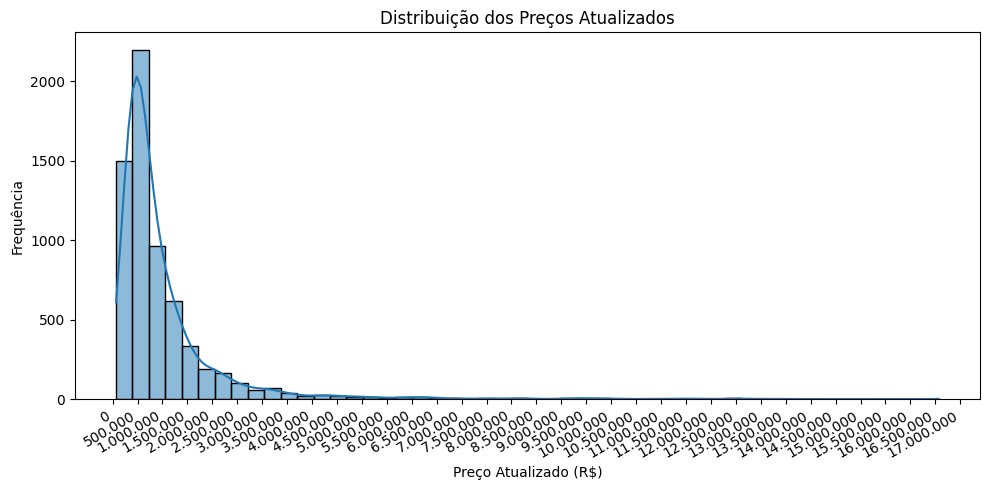

In [4]:
plt.figure(figsize=(10, 5)) 
ax = sns.histplot(df['Price_atualizado'], bins=50, kde=True) 
plt.title('Distribui√ß√£o dos Pre√ßos Atualizados')
plt.xlabel('Pre√ßo Atualizado (R$)')
plt.ylabel('Frequ√™ncia')

# 1. Desativa a nota√ß√£o cient√≠fica
plt.ticklabel_format(style='plain', axis='x')

# 2. Formata os n√∫meros para o padr√£o brasileiro (ex: 1.000.000)
formatter = ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
ax.xaxis.set_major_formatter(formatter)

# 3. Define manualmente os locais dos ticks no eixo X
ticks = np.arange(0, df['Price_atualizado'].max() + 500_000, 500_000)
plt.xticks(ticks, rotation=30, ha='right') 

plt.tight_layout() 
plt.show()


C:\Users\luuka\AppData\Local\Temp\ipykernel_24704\2256231311.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x=bairro_counts.values, y=bairro_counts.index, palette='viridis')
C:\Users\luuka\AppData\Local\Temp\ipykernel_24704\2256231311.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Median_Price_Atualizada', y='Bairro', data=bairro_price_top, palette='magma')


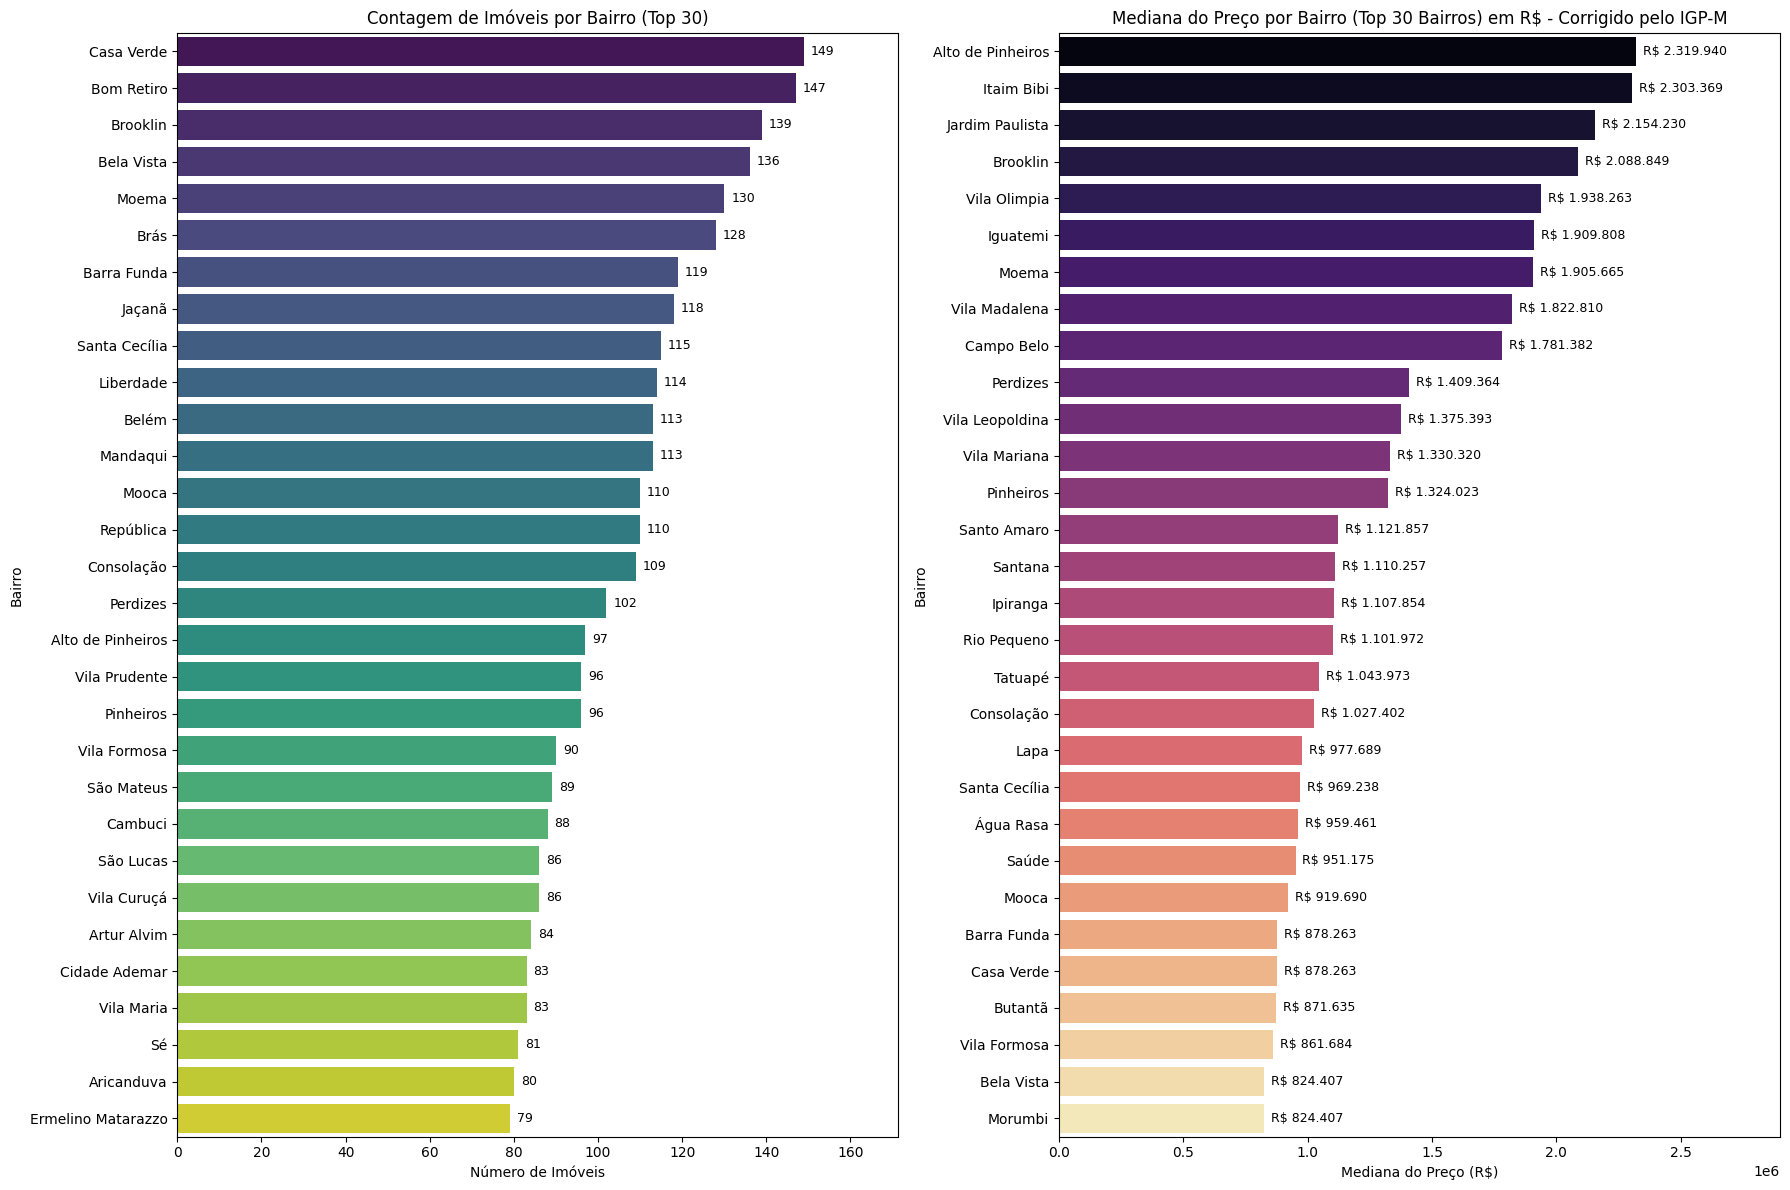

In [5]:
plt.figure(figsize=(18, 12)) 

# Contagem de Im√≥veis por Bairro (Top 30) - COM R√ìTULOS
plt.subplot(1, 2, 1)

bairro_counts = df['bairro'].value_counts().head(30)
ax1 = sns.barplot(x=bairro_counts.values, y=bairro_counts.index, palette='viridis')
plt.title('Contagem de Im√≥veis por Bairro (Top 30)')
plt.xlabel('N√∫mero de Im√≥veis')
plt.ylabel('Bairro')

for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width()):,}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points', 
                fontsize=9)
    
ax1.set_xlim(right=bairro_counts.max() * 1.15)

# ----------------------------------------------------
# Mediana do Pre√ßo (R$) por BAIRRO (Top 30) - AJUSTADA PELO IGPM
plt.subplot(1, 2, 2)

# 1. Agrupa por 'bairro' e calcula a Mediana da coluna ATUALIZADA
bairro_price_median = df.groupby('bairro')['Price_atualizado'].median().sort_values(ascending=False).reset_index()
bairro_price_median.columns = ['Bairro', 'Median_Price_Atualizada']

# 2. Seleciona os Top 30 bairros com a mediana mais alta
top_n = 30
bairro_price_top = bairro_price_median.head(top_n)

# 3. Cria o gr√°fico de barras
ax2 = sns.barplot(x='Median_Price_Atualizada', y='Bairro', data=bairro_price_top, palette='magma')
plt.title(f'Mediana do Pre√ßo por Bairro (Top {top_n} Bairros) em R$ - Corrigido pelo IGP-M')
plt.xlabel('Mediana do Pre√ßo (R$)')
plt.ylabel('Bairro')

# 4. Adiciona os r√≥tulos de dados (Pre√ßo em R$)
for p in ax2.patches:
    # Formata o valor como R$ X.XXX.XXX
    value = f"R$ {p.get_width():,.0f}".replace(',', '_').replace('.', ',').replace('_', '.')
    
    ax2.annotate(value, 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points', 
                fontsize=9)

ax2.set_xlim(right=bairro_price_top['Median_Price_Atualizada'].max() * 1.25)


plt.tight_layout()
plt.show()

C:\Users\luuka\AppData\Local\Temp\ipykernel_24704\1496320768.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Mediana_Preco_M2', y='Bairro', data=bairro_m2_top, palette='viridis')


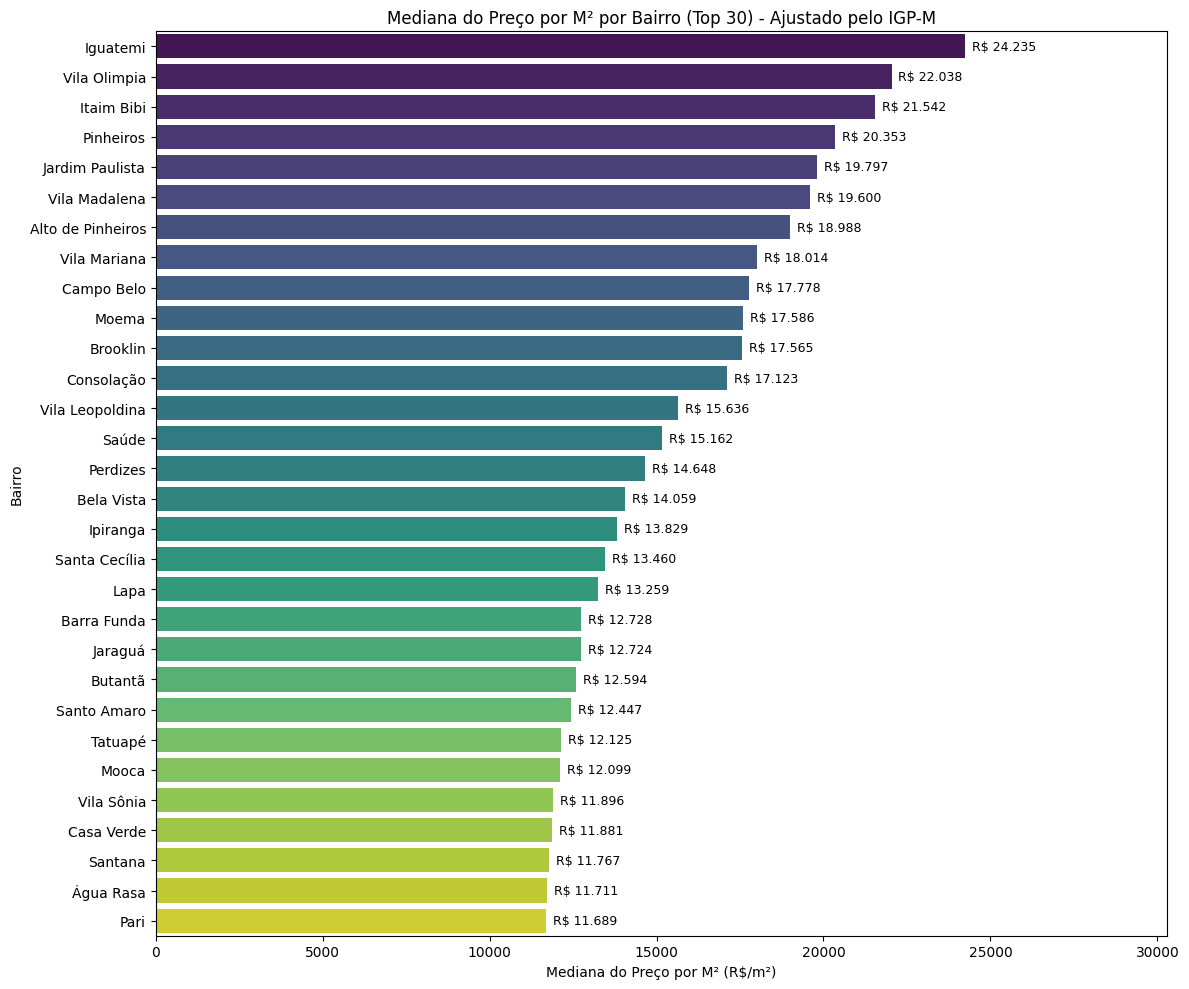


Top 5 Bairros por Mediana de Pre√ßo/M¬≤ (R$/m¬≤):
            Bairro  Mediana_Preco_M2
0         Iguatemi           24235.0
1     Vila Olimpia           22038.0
2       Itaim Bibi           21542.0
3        Pinheiros           20353.0
4  Jardim Paulista           19797.0


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Criar a m√©trica R$/m¬≤ (usando o pre√ßo ajustado)
df['preco_m2_ajustado'] = df['Price_atualizado'] / df['Size']

# 2. Calcular a Mediana do R$/m¬≤ por Bairro
# A mediana √© mais robusta contra outliers extremos do que a m√©dia.
m2_median_por_bairro = df.groupby('bairro')['preco_m2_ajustado'].median().sort_values(ascending=False).reset_index()
m2_median_por_bairro.columns = ['Bairro', 'Mediana_Preco_M2']

# 3. Selecionar os Top 30 Bairros para visualiza√ß√£o
top_n = 30
bairro_m2_top = m2_median_por_bairro.head(top_n)

# 4. Gerar o gr√°fico de barras
plt.figure(figsize=(12, 10))

ax = sns.barplot(x='Mediana_Preco_M2', y='Bairro', data=bairro_m2_top, palette='viridis')
plt.title(f'Mediana do Pre√ßo por M¬≤ por Bairro (Top {top_n}) - Ajustado pelo IGP-M')
plt.xlabel('Mediana do Pre√ßo por M¬≤ (R$/m¬≤)')
plt.ylabel('Bairro')

# 5. Adicionar r√≥tulos de dados (Data Labels)
for p in ax.patches:
    # Formata o valor como R$ X.XXX (inteiro sem casas decimais)
    value = f"R$ {p.get_width():,.0f}".replace(',', '_').replace('.', ',').replace('_', '.')
    
    ax.annotate(value, 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points', 
                fontsize=9)

# Ajusta o limite do eixo X para dar espa√ßo aos r√≥tulos
ax.set_xlim(right=bairro_m2_top['Mediana_Preco_M2'].max() * 1.25)

plt.tight_layout()
plt.show()

# Exibe os 5 bairros com a Mediana de Pre√ßo/m¬≤ mais alta para refer√™ncia
print("\nTop 5 Bairros por Mediana de Pre√ßo/M¬≤ (R$/m¬≤):")
print(bairro_m2_top.head(5).round(0))

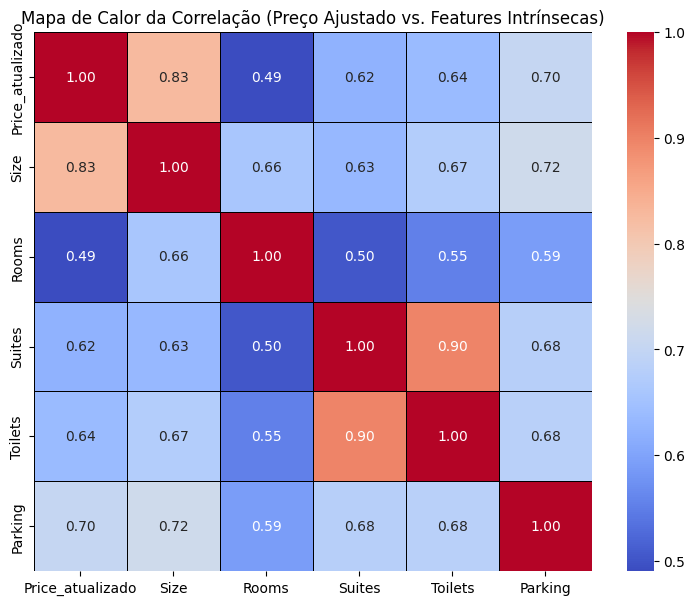


Correla√ß√£o do Pre√ßo Atualizado com as Features:
Price_atualizado    1.00
Size                0.83
Parking             0.70
Toilets             0.64
Suites              0.62
Rooms               0.49
Name: Price_atualizado, dtype: float64


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NOTA: O 'df' deve ter a coluna 'Price_atualizado' criada em uma c√©lula anterior
# Se voc√™ n√£o a criou, descomente e execute a linha abaixo:
# IGPM_MULTIPLIER = 1.6571
# df['Price_atualizado'] = df['Price'] * IGPM_MULTIPLIER

# 1. Definir as features para an√°lise
features_numericas = ['Price_atualizado', 'Size', 'Rooms', 'Suites', 'Toilets', 'Parking']

# 2. Calcular a Matriz de Correla√ß√£o
# Usamos a Correla√ß√£o de Pearson
corr_matrix = df[features_numericas].corr()

# 3. Gerar o Mapa de Calor
plt.figure(figsize=(9, 7))

# Configura√ß√µes do Heatmap:
# annot=True: Mostra o valor da correla√ß√£o dentro de cada c√©lula
# fmt=".2f": Formata o n√∫mero com 2 casas decimais
# cmap='coolwarm': Usa um esquema de cores que destaca correla√ß√£o positiva (vermelho) e negativa (azul)
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=.5, 
            linecolor='black')

plt.title('Mapa de Calor da Correla√ß√£o (Pre√ßo Ajustado vs. Features Intr√≠nsecas)')
plt.show()

print("\nCorrela√ß√£o do Pre√ßo Atualizado com as Features:")
print(corr_matrix.loc['Price_atualizado'].sort_values(ascending=False).round(2))

#### 5. Pr√©-processamento e Treinamento do Modelo
Este bloco define o ColumnTransformer (nosso encoder), que aplica a escala (StandardScaler) aos dados num√©ricos e o One-Hot Encoding aos dados categ√≥ricos. Em seguida, treina o modelo XGBRegressor e define as vari√°veis globais essenciais (xgb, encoder_ou_pipeline, all_features_names).

In [9]:
# Defini√ß√£o das Features e Target
features = ['Size', 'Rooms', 'Parking', 'Suites', 'Toilets', 'bairro', 'Regiao']
X = df[features]
y = np.log1p(df['Price']) # Usando a transforma√ß√£o logar√≠tmica

# Split dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Defini√ß√£o do ColumnTransformer
num_features = ['Size', 'Rooms', 'Parking', 'Suites', 'Toilets']
cat_features = ['bairro', 'Regiao']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
    ],
    remainder='drop',
    verbose_feature_names_out=False
).set_output(transform='pandas')

# Vari√°veis globais essenciais: ENCODER E NOMES DAS FEATURES
encoder_ou_pipeline = preprocessor.fit(X_train)
X_train_encoded = encoder_ou_pipeline.transform(X_train)
all_features_names = list(encoder_ou_pipeline.get_feature_names_out())

# Defini√ß√£o e Treinamento do modelo XGBoost (Vari√°vel global: xgb)
xgb = xgb(
    n_estimators=1000, 
    learning_rate=0.05, 
    max_depth=5, 
    subsample=0.8, 
    colsample_bytree=0.8, 
    random_state=42, 
    tree_method='hist'
)
xgb.fit(X_train_encoded, y_train) 

print("=========================================================")
print("Treinamento conclu√≠do. O modelo e o encoder est√£o prontos.")
print("=========================================================")

Treinamento conclu√≠do. O modelo e o encoder est√£o prontos.


#### 4. Fun√ß√µes de Previs√£o Interativa
Este bloco cont√©m as duas fun√ß√µes finais: prever_preco (o motor) e previsao_interativa (a interface). Ambas foram corrigidas para acessar as vari√°veis globais e reverter a transforma√ß√£o logar√≠tmica para retornar o pre√ßo em Reais (R$).

In [10]:
# Definir o multiplicador do IGPM globalmente
IGPM_MULTIPLIER = 1.6571

def prever_preco(Size, Rooms, Parking, bairro, Suites, Toilets, Regiao):
    """
    Motor do modelo que transforma os dados de entrada e calcula o pre√ßo base (Abr/2019).
    """
    
    global encoder_ou_pipeline, all_features_names, xgb 
    
    # 1. Criar o DataFrame de entrada
    dados_entrada = pd.DataFrame({
        'Size': [Size], 'Rooms': [Rooms], 'Parking': [Parking], 
        'Suites': [Suites], 'Toilets': [Toilets], 'bairro': [bairro], 'Regiao': [Regiao]
    })
    
    try:
        # 2. Transformar os dados e prever (resultado em escala logar√≠tmica)
        X_encoded_df = encoder_ou_pipeline.transform(dados_entrada)
        previsao_log = xgb.predict(X_encoded_df)
        
        # 3. Reverter a transforma√ß√£o logar√≠tmica para obter o pre√ßo de ABR/2019
        preco_base = np.expm1(previsao_log)
        
        return preco_base[0]

    except Exception as e:
        print(f"Erro no m√≥dulo de previs√£o: {e}")
        return None


def previsao_interativa():
    """Fun√ß√£o interativa que coleta dados do usu√°rio, aplica o IGPM e exibe a previs√£o."""
    
    print("\n=== PREVIS√ÉO DE PRE√áOS DE IM√ìVEIS EM S√ÉO PAULO ===")
    print(f"**Ajuste monet√°rio: IGP-M acumulado de 65,71% (Desde Abr/2019 at√© Out/2025)**")
    print("Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):\n")
    
    global mapeamento_regioes 
    
    try:
        # ----------------------------------------------------
        # üìå IMPLEMENTA√á√ÉO COMPLETA DOS INPUTS DO USU√ÅRIO
        # ----------------------------------------------------
        print("‚ñå DADOS DO IM√ìVEL ‚ñå")
        
        # √Årea
        Size = input("‚Ä¢ √Årea constru√≠da (m¬≤): ")
        if Size.lower() == 'sair': return
        Size = float(Size)
        if Size <= 10:
            print("‚ùå Valor inv√°lido. A √°rea m√≠nima deve ser maior que 10m¬≤. Digite novamente.")
            return
            
        # Quartos
        Rooms = input("‚Ä¢ N√∫mero de quartos: ")
        if Rooms.lower() == 'sair': return
        Rooms = int(Rooms)
        if Rooms < 1:
            print("‚ùå Valor inv√°lido. O valor m√≠nimo √© 1.")
            return
            
        # Su√≠tes
        Suites = input("‚Ä¢ N√∫mero de su√≠tes: ")
        if Suites.lower() == 'sair': return
        Suites = int(Suites)
        
        # Banheiros
        Toilets = input("‚Ä¢ N√∫mero de banheiros: ")
        if Toilets.lower() == 'sair': return
        Toilets = int(Toilets)
        if Toilets < 1:
            print("‚ùå Valor inv√°lido. O valor m√≠nimo √© 1.")
            return
            
        # Garagem
        Parking = input("‚Ä¢ Vagas de garagem: ")
        if Parking.lower() == 'sair': return
        Parking = int(Parking)
        
        # Coleta de localiza√ß√£o
        print("\n‚ñå LOCALIZA√á√ÉO ‚ñå")
        while True:
            bairro = input("‚Ä¢ Bairro (ex: 'Pinheiros', 'Moema'): ").strip().title()
            if bairro.lower() == 'sair': return
            Regiao = mapeamento_regioes.get(bairro, None)
            if Regiao is not None:
                break
            else:
                print(f"Bairro '{bairro}' n√£o encontrado no nosso mapeamento. Por favor, digite novamente.")
        
        # ----------------------------------------------------
        
        print(f"\n‚ÑπÔ∏è Regi√£o determinada automaticamente: {Regiao}")
        
        # Fazer previs√£o
        preco_base = prever_preco(
            Size=Size, Rooms=Rooms, Parking=Parking, bairro=bairro, 
            Suites=Suites, Toilets=Toilets, Regiao=Regiao
        )
        
        # Corre√ß√£o do IGPM
        preco_estimado_atualizado = preco_base * IGPM_MULTIPLIER
        
        # Mostrar resultado
        if preco_base is not None:
            
            print("\n" + "="*60)
            print("üìã RESUMO DOS DADOS INFORMADOS")
            print("-"*60)
            print(f"‚ñ™ √Årea constru√≠da: {Size} m¬≤")
            print(f"‚ñ™ Quartos: {Rooms} (Su√≠tes: {Suites})")
            print(f"‚ñ™ Banheiros: {Toilets}")
            print(f"‚ñ™ Vagas: {Parking}")
            print(f"‚ñ™ Localiza√ß√£o: {bairro} - {Regiao}")
            
            print("\nüí≤ RESULTADO DA PREVIS√ÉO")
            print("-"*60)
            
            # Valor final corrigido pelo IGPM
            print(f"Valor estimado (Corrigido pelo IGPM): R$ {preco_estimado_atualizado:,.2f}")
            
            # Faixa sugerida corrigida pelo IGPM
            faixa_minima = preco_estimado_atualizado * 0.85
            faixa_maxima = preco_estimado_atualizado * 1.15
            print(f"Faixa sugerida: R$ {faixa_minima:,.2f} a R$ {faixa_maxima:,.2f}")
            print("="*60)
        else:
            print("\nN√£o foi poss√≠vel calcular a previs√£o.")
            
    except ValueError:
        print("\nErro: Por favor, digite valores num√©ricos nos campos solicitados.")
    except Exception as e:
        print(f"\nOcorreu um erro: {str(e)}")

# ====================================================================
# 5. EXECU√á√ÉO
# ====================================================================
print("\nINSTRU√á√ïES:")
print("1. Digite apenas o nome do bairro (ex: 'Pinheiros')")
print("2. O sistema identificar√° automaticamente a regi√£o")
print("3. Digite 'sair' a qualquer momento para cancelar\n")

previsao_interativa()


INSTRU√á√ïES:
1. Digite apenas o nome do bairro (ex: 'Pinheiros')
2. O sistema identificar√° automaticamente a regi√£o
3. Digite 'sair' a qualquer momento para cancelar


=== PREVIS√ÉO DE PRE√áOS DE IM√ìVEIS EM S√ÉO PAULO ===
**Ajuste monet√°rio: IGP-M acumulado de 65,71% (Desde Abr/2019 at√© Out/2025)**
Por favor, informe os dados solicitados (digite 'sair' a qualquer momento para cancelar):

‚ñå DADOS DO IM√ìVEL ‚ñå

‚ñå LOCALIZA√á√ÉO ‚ñå

‚ÑπÔ∏è Regi√£o determinada automaticamente: Zona Oeste

üìã RESUMO DOS DADOS INFORMADOS
------------------------------------------------------------
‚ñ™ √Årea constru√≠da: 60.0 m¬≤
‚ñ™ Quartos: 2 (Su√≠tes: 1)
‚ñ™ Banheiros: 2
‚ñ™ Vagas: 1
‚ñ™ Localiza√ß√£o: Pinheiros - Zona Oeste

üí≤ RESULTADO DA PREVIS√ÉO
------------------------------------------------------------
Valor estimado (Corrigido pelo IGPM): R$ 1,098,090.25
Faixa sugerida: R$ 933,376.75 a R$ 1,262,803.75


#### 6. An√°lise de Import√¢ncia de Features (Feature Importance)

In [11]:
from sklearn.preprocessing import LabelEncoder

# Criar uma c√≥pia para evitar alterar os dados originais
X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

# Codificar colunas categ√≥ricas
for col in ['Regiao', 'bairro']:
    le = LabelEncoder()
    X_train_enc[col] = le.fit_transform(X_train_enc[col])
    X_test_enc[col] = le.transform(X_test_enc[col])

# Treinar o modelo novamente
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42
)

xgb.fit(X_train_enc, y_train)
preds = xgb.predict(X_test_enc)

   feature  importance
2  Parking    0.331054
0     Size    0.319508
6   Regiao    0.102477
3   Suites    0.080361
1    Rooms    0.063596
5   bairro    0.056267
4  Toilets    0.046736


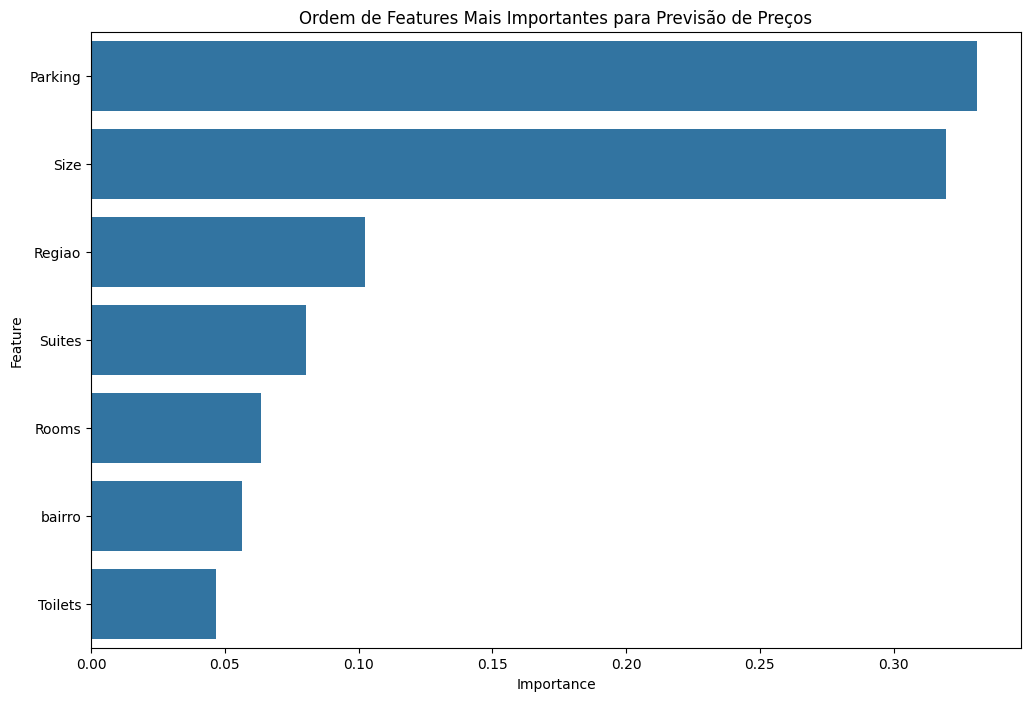

In [14]:
# Extrair import√¢ncias
importances = xgb.feature_importances_

# Criar DataFrame de import√¢ncia
feature_importances = pd.DataFrame({
    'feature': X_train_enc.columns,   # ou X_train_cat.columns, conforme seu caso
    'importance': importances}).sort_values(by='importance', ascending=False)

# Mostrar top 10
print(feature_importances.head(10))
from sklearn.pipeline import Pipeline

# Exemplo de como acessar o modelo e as features corretamente em um Pipeline
# Assumindo que o pipeline tem o nome 'model' para o XGBRegressor

# Se 'xgb' no seu c√≥digo for, na verdade, o seu Pipeline:
# SUPOSTO C√ìDIGO CORRETO (SE 'xgb' FOR UM PIPELINE)
if isinstance(xgb, Pipeline):
    # Acessa o estimador final (o XGBRegressor)
    xgb_model = xgb.named_steps['nome_da_etapa_do_modelo'] # Ex: 'xgb_regressor'
    # Extrai os nomes das features do ColumnTransformer
    importances = xgb_model.feature_importances_
    # ... e o resto do seu c√≥digo

# DEFINA ISTO PRIMEIRO (assumindo que X_train_enc √© seu dataset de treinamento processado)
all_features = X_train.columns
importances = xgb.feature_importances_ # Lembre-se de extrair os valores do modelo

# Ent√£o execute o DataFrame
importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Visualiza√ß√£o
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Ordem de Features Mais Importantes para Previs√£o de Pre√ßos')
for p in ax.patches:
    # Formata o valor para 4 casas decimais para manter a precis√£o
    ax.annotate(f'{p.get_width():.4f}', 
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points', 
                fontsize=10)
plt.show()

C:\Users\luuka\AppData\Local\Temp\ipykernel_24704\1211554268.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Spectral')


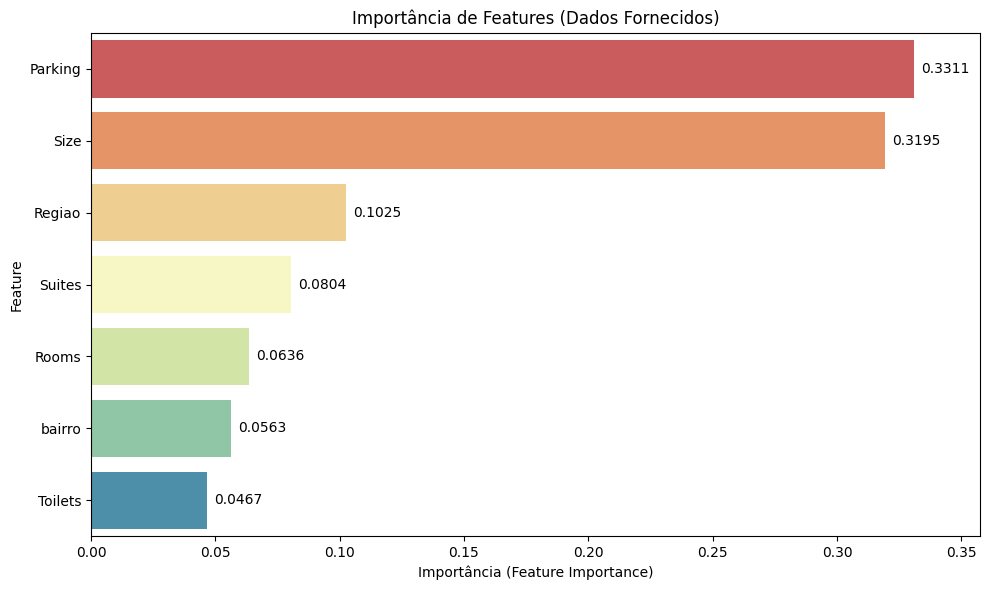


DataFrame utilizado:
   Feature  Importance
0  Parking    0.331054
1     Size    0.319508
2   Regiao    0.102477
3   Suites    0.080361
4    Rooms    0.063596
5   bairro    0.056267
6  Toilets    0.046736


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Dados fornecidos pelo usu√°rio, corrigidos para cria√ß√£o de DataFrame
data = {
    'Feature': ['Parking', 'Size', 'Regiao', 'Suites', 'Rooms', 'bairro', 'Toilets'],
    'Importance': [0.331054, 0.319508, 0.102477, 0.080361, 0.063596, 0.056267, 0.046736]
}

importance_df = pd.DataFrame(data)

# Ordenar os dados para o gr√°fico (j√° est√£o ordenados, mas para garantir)
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# 1. Configurar o gr√°fico
plt.figure(figsize=(10, 6))

# Gerar o gr√°fico de barras e capturar o objeto 'ax' para r√≥tulos
ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Spectral')

plt.title('Import√¢ncia de Features (Dados Fornecidos)')
plt.xlabel('Import√¢ncia (Feature Importance)')
plt.ylabel('Feature')

# 2. Adicionar R√ìTULOS DE DADOS
for p in ax.patches:
    # Formata o valor para 4 casas decimais para visualiza√ß√£o
    ax.annotate(f'{p.get_width():.4f}', 
                # Posi√ß√£o do r√≥tulo: no final da barra (p.get_width())
                (p.get_width(), p.get_y() + p.get_height() / 2.), 
                ha='left', va='center', 
                xytext=(5, 0), # Pequeno deslocamento horizontal
                textcoords='offset points', 
                fontsize=10)

# Ajustar o limite do eixo X para garantir espa√ßo para os r√≥tulos
ax.set_xlim(right=importance_df['Importance'].max() * 1.08)

plt.tight_layout()
plt.show()

print("\nDataFrame utilizado:")
print(importance_df)